In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [3]:
cuda = torch.cuda.is_available()

In [4]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor   if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor   if use_cuda else torch.ByteTensor
def convert_to_var(arr, astype='float32', add_dim=False):
    if add_dim:
        arr = np.array([arr])
    if astype == 'float32':
        v = Variable(FloatTensor(arr.astype(astype))) 
    else:
        v = Variable(LongTensor(arr.astype(astype)))
    return v

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [6]:
class VAE(nn.Module):
    def __init__(self, input_shape=(-1, 10),
                 latent_dim=2, n_samples=10,
                 fc_size=1024, num_layers=2):
        super(VAE, self).__init__()
        self.n_samples = n_samples
        self.bias = Variable(FloatTensor([100]))

        self.input_shape = input_shape
        
        encoder_layers = []
        encoder_layers.append(nn.Linear(input_shape[-1], fc_size, bias=False))
        encoder_layers.append(nn.ReLU())
        for i in range(1,num_layers):
            encoder_layers.append(nn.Linear(fc_size//2**(i-1), fc_size//2**i, bias=False))
            encoder_layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*encoder_layers)
            
        self.fc_mu = nn.Linear(fc_size//2**(num_layers-1), latent_dim, bias=False)
        self.fc_logvar = nn.Linear(fc_size//2**(num_layers-1), latent_dim)
        
        decoder_layers = []
        decoder_layers.append(nn.Linear(latent_dim, fc_size//2**(num_layers-1)))
        decoder_layers.append(nn.ReLU())
        
        for i in range(num_layers-1):
            decoder_layers.append(nn.Linear(fc_size//2**(num_layers-1-i), fc_size//2**(num_layers-i-2)))
            decoder_layers.append(nn.ReLU())
        decoder_layers.append(nn.Linear(fc_size, 2*input_shape[1]))
        self.decoder = nn.Sequential(*decoder_layers)

    def encode(self, x):
        enc_out = self.encoder(x)
        mu_ = self.fc_mu(enc_out)
        return  mu_ + self.bias.expand(mu_.size()), self.fc_logvar(enc_out)

    def reparameterize(self, mu, logvar):
        if self.training:
            n_samples = self.n_samples
            batch_size = mu.shape[0]
            latent_dim = mu.shape[1]
            eps = np.random.randn(batch_size*latent_dim*n_samples)\
                                 .reshape((batch_size, n_samples, latent_dim))
            eps = convert_to_var(eps)
            std = logvar.mul(0.5).exp_()
            mu = mu.view(-1, 1, latent_dim)
            std = std.view(-1, 1, latent_dim)
            return mu + eps*std
        else:
            return mu

    def decode(self, z):
        dec_out = self.decoder(z)
        if len(dec_out.shape) == 3:
            dec_out = dec_out.view(-1, self.n_samples, self.input_shape[1], 2)
            probs = F.softmax(dec_out, dim=-1)
            log_probs = F.log_softmax(dec_out, dim=-1)
            recon_x = probs[:,:,:,1]
        else:
            dec_out = self.decoder(z)
            dec_out = dec_out.view(-1, self.input_shape[1], 2)
            probs = F.softmax(dec_out, dim=-1)
            log_probs = F.log_softmax(dec_out, dim=-1)   
            recon_x = probs[:,:,1]
        return recon_x, log_probs

    
    def forward(self, x):
        mu, logvar = self.encode(x.view(self.input_shape))
        z = self.reparameterize(mu, logvar)
        recon_x, log_probs = self.decode(z)
        return recon_x, log_probs, mu, logvar

In [7]:
def loss_function(log_probs, x, mu, logvar, n_samples=10):
    KLD = 0.5 * torch.mean(
                      torch.sum(mu.pow(2) + logvar.exp() - 1 - logvar, dim=1))
    
    if len(log_probs.shape)==4:
        x = x.view(-1, 1, x.shape[1]).clone()
        x = x.repeat(1, n_samples, 1)
        LL = torch.sum((1-x)*log_probs[:,:,:,0] + x * log_probs[:,:,:,1]) / (x.shape[0]*n_samples)
    else:
        LL = torch.sum((1-x)*log_probs[:,:,0] + x * log_probs[:,:,1]) / (x.shape[0])

    elbo = LL - KLD
    loss = -1 * elbo
    return  loss, LL, KLD

In [8]:
from IPython.display import clear_output
from tqdm import trange

# функция для итераций по минибатчам, из первого семинара
def iterate_minibatches(inputs, batchsize, shuffle=True):
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [9]:
def train_epoch(model, optimizer, X_adversarial=None, batchsize=32):
    loss_log = []
    ll_log = []
    kld_log = []
        
    for x_batch in iterate_minibatches(X_train, batchsize=batchsize, shuffle=True):
        model.train()
        data = convert_to_var(x_batch.astype(np.float32))
        optimizer.zero_grad()
        recon_batch, log_probs, mu, logvar = model(data)
        loss, ll, kld = loss_function(log_probs, data, mu, logvar, model.n_samples)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.data[0])
        ll_log.append(ll.data[0])
        kld_log.append(kld.data[0])
        
    return loss_log, ll_log, kld_log

In [10]:
def train(model, optimizer, num_epochs=5, batchsize=32):
    loss_log = []
    ll_log = []
    kld_log = []
    
    for i in range(num_epochs):
        epoch_results = train_epoch(model, optimizer, batchsize=batchsize)    
        loss_log += epoch_results[0]
        ll_log += epoch_results[1]
        kld_log += epoch_results[2]
        
    return loss_log, ll_log, kld_log

In [11]:
from matplotlib.patches import Ellipse

colors = ['red', 'green', 'blue', 'orange', 'pink']
def plot_point_with_std(mu, std):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, aspect='equal')

    e = Ellipse([0,0], 6, 6)
    e.set_alpha(0.75)
    e.set_facecolor('white')
    e.set_edgecolor('black')
    ax.add_artist(e)

    
    for i in range(len(mu)):
        e = Ellipse(mu[i], 6*std[i][0], 6*std[i][1])
        e.set_alpha(0.25)
        e.set_facecolor('gray')
        ax.add_artist(e)

        plt.plot(mu[i][0], mu[i][1], '.', markersize=15,
                 color=colors[i], alpha=0.8)
    plt.grid()
    plt.title('title')
    plt.xlim((-4,4))
    plt.ylim((-4,4))

In [12]:
def plot_learning_history(logs, filename=None):
    
    loss_log, ll_log, kld_log = logs
    
    plt.figure(figsize=(15, 5))
    linewidth = 4
    
    plt.subplot(1, 3, 1)
    plt.plot(loss_log)
    plt.title('Loss')
    
    plt.subplot(1, 3, 2)
    plt.plot(ll_log)
    plt.title('LL')
    
    plt.subplot(1, 3, 3)
    plt.plot(kld_log)
    plt.title('KL')
    
    plt.grid()
    
    if filename is not None:
        plt.savefig(filename)

In [13]:
dim=50
num_classes = 5

In [14]:
def get_one_hot_object(obj_class, dim, num_classes):
    x = np.zeros(dim)
    x[:(dim//num_classes) * (obj_class+1)] = 1
    return x

In [15]:
X_train = []
num_per_class = 250
for i in range(num_classes):
    for j in range(num_per_class):
        X_train.append(get_one_hot_object(i,
                                          dim, num_classes))
X_train = np.array(X_train)

In [16]:
X_train.shape

(1250, 50)

## Обучение по батчам, 2 слоя

In [17]:
X_train.shape

(1250, 50)

In [18]:
%%time
model = VAE(latent_dim=2, input_shape=(-1,dim), n_samples=25, fc_size=1024, num_layers=2)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_logs = train(model, optimizer, num_epochs=25, batchsize=32)
clear_output()

CPU times: user 2min 53s, sys: 1.11 s, total: 2min 54s
Wall time: 1min 12s


In [19]:
print(model)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=50, out_features=1024)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=512, out_features=2)
  (fc_logvar): Linear(in_features=512, out_features=2)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=512)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=100)
  )
)


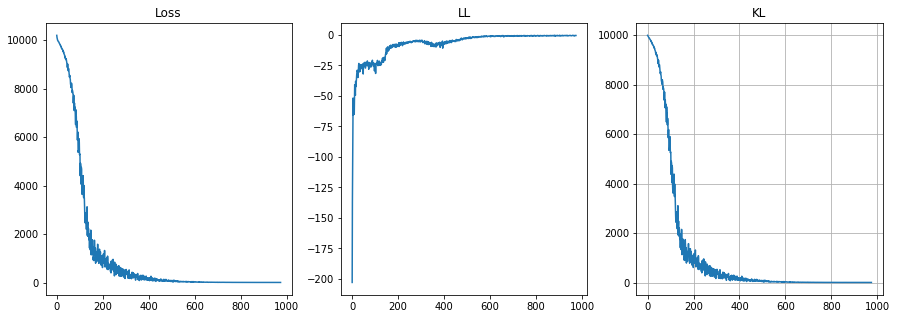

In [20]:
plot_learning_history(train_logs)

In [21]:
train_logs[1][-10:]

[-0.6807293891906738,
 -0.4823472499847412,
 -0.6689685583114624,
 -0.7412463426589966,
 -0.46892932057380676,
 -0.4540080726146698,
 -0.3304220139980316,
 -0.4076208770275116,
 -0.38563773036003113,
 -0.4322448670864105]

In [22]:
X_test = []
for i in range(num_classes):
    X_test.append(get_one_hot_object(i, dim, num_classes))
X_test = np.array(X_test)

In [23]:
model.eval()
recon_batch, log_probs, mu, logvar = model(convert_to_var(X_test))
recon_batch = recon_batch.data.numpy()
log_probs = log_probs.data.numpy()
mu = mu.data.numpy()
logvar = logvar.data.numpy()
std = np.exp(0.5*logvar)

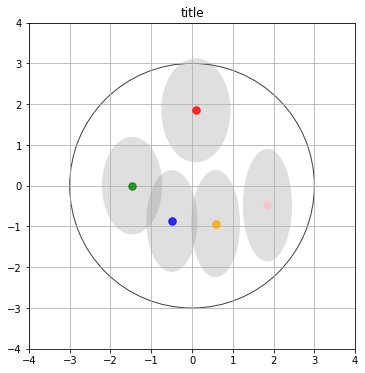

In [24]:
plot_point_with_std(mu, std)

## Обучение по батчам, 4 слоя

In [25]:
%%time
model = VAE(latent_dim=2, input_shape=(-1,dim), n_samples=25, fc_size=1024, num_layers=4)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_logs = train(model, optimizer, num_epochs=50, batchsize=32)
clear_output()

CPU times: user 7min 27s, sys: 4.16 s, total: 7min 31s
Wall time: 3min 19s


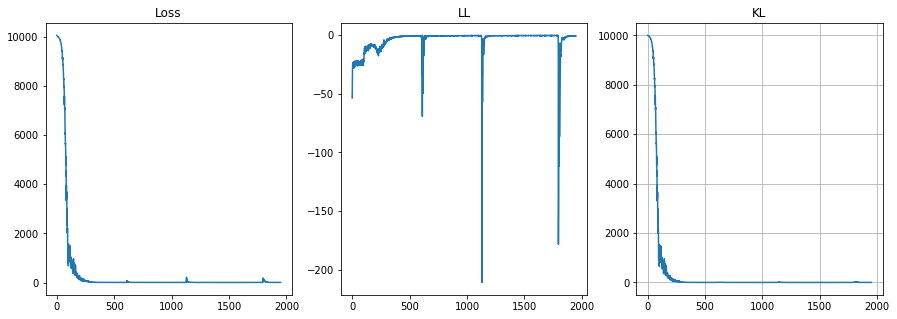

In [26]:
plot_learning_history(train_logs)

In [27]:
print(model)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=50, out_features=1024)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=128)
    (7): ReLU()
  )
  (fc_mu): Linear(in_features=128, out_features=2)
  (fc_logvar): Linear(in_features=128, out_features=2)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=1024)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=100)
  )
)


In [28]:
train_logs[1][-10:]

[-0.5904467105865479,
 -0.5204548835754395,
 -0.4955577552318573,
 -0.6006147265434265,
 -0.4964387118816376,
 -0.5229891538619995,
 -0.6338591575622559,
 -0.49669867753982544,
 -0.4772299528121948,
 -0.5681867003440857]

In [29]:
model.eval()
recon_batch, log_probs, mu, logvar = model(convert_to_var(X_test))
recon_batch = recon_batch.data.numpy()
log_probs = log_probs.data.numpy()
mu = mu.data.numpy()
logvar = logvar.data.numpy()
std = np.exp(0.5*logvar)

In [30]:
mu

array([[ 1.4865875 ,  0.7896271 ],
       [ 0.7553482 ,  0.25819397],
       [ 0.11479187, -0.24730682],
       [-0.56559753, -0.86964417],
       [-1.3319168 , -1.5895996 ]], dtype=float32)

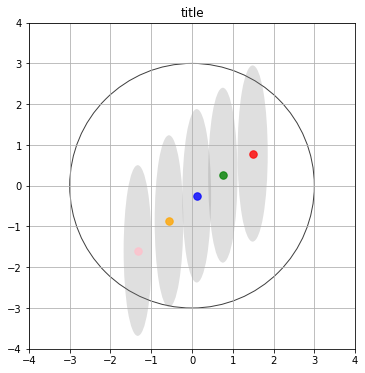

In [31]:
plot_point_with_std(mu, std)

# Онлайн-обучение

In [32]:
x = np.arange(0, 1000, 1)
y1 = 1-0.9**x
y2 = 1-0.99**x

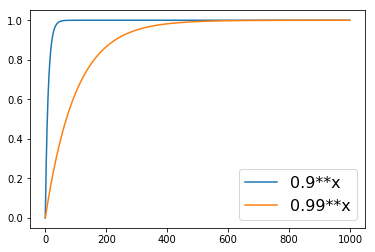

In [33]:
plt.plot(y1, label='0.9**x')
plt.plot(y2, label='0.99**x')
plt.legend(loc='lower right', fontsize=16)

### Стационарные данные

In [34]:
X_test.shape

(5, 50)

In [35]:
def get_pseudo_count_from_pg(pg, damp_coef):
    eps = 1e-4
    t = np.exp(max(damp_coef * pg, eps)) - 1
    pseudo_count = 1 / t
    
    return pseudo_count

In [36]:
def get_pseudo_count_from_probs(p0, p1):
    eps = 1e-3
    pseudo_count = p0 * (1 - p1) / max(p1 - p0, eps)
    
    return pseudo_count

In [37]:
def get_obj_log_prob(model, obj, return_loss=False):
    x = np.array([obj])
    probs, log_probs, mu, logvar = model(convert_to_var(x))
    
    if return_loss:
        loss, ll, kld = loss_function(log_probs, convert_to_var(x), mu, logvar, model.n_samples)

    log_probs = log_probs.data.numpy()[0].mean(axis=0)
    log_probs = log_probs[np.arange(dim), obj.astype('int64')]
    obj_log_prob = log_probs.sum()

    if return_loss:
        return obj_log_prob, loss, ll, kld
    else:
        return obj_log_prob

In [38]:
def plot_different_pgs():

    filtered_pgs_by_sq_n = [[] for _ in range(num_classes)]
    filtered_pgs_by_n = [[] for _ in range(num_classes)]
    filtered_pgs = [[] for _ in range(num_classes)]


    for i in range(len(chosen_classes)):
        cur_class = chosen_classes[i]
        filtered_pgs[cur_class].append( pgs[i] )
        filtered_pgs_by_n[cur_class].append( pgs[i]/(i+1) )
        filtered_pgs_by_sq_n[cur_class].append( pgs[i]/np.sqrt((i+1)) )

    filtered = [filtered_pgs, filtered_pgs_by_sq_n, filtered_pgs_by_n]
    names = ['PG_n', 'PG_n / sqrt(n)', 'PG_n / n']
    y_limits = [(-2, 10), (-0.1, 0.5), (-0.05,0.1)]

    plt.figure(figsize=(25,15))
    for j in range(len(filtered)):
        for i in range(num_classes):
            plt.subplot(3,5,5*j+i+1)
            plt.plot(filtered[j][i], label='class {}'.format(i+1))
            plt.axhline(y=0, color='red')

            plt.grid()
            plt.title(names[j], fontsize=20)
            plt.ylim(y_limits[j])
            plt.legend(loc='upper right', fontsize=15)

In [39]:
def plot_pgs(chosen_classes, pgs, filename=None):
    filtered_pgs = [[] for _ in range(num_classes)]

    for i in range(len(chosen_classes)):
        cur_class = chosen_classes[i]
        filtered_pgs[cur_class].append( pgs[i] )

    plt.figure(figsize=(25,5))
    for i in range(num_classes):
        plt.subplot(1,5,i+1)
        plt.plot(filtered_pgs[i], label='class {}'.format(i+1))
        plt.axhline(y=0, color='red')

        plt.grid()
        plt.title('PG', fontsize=20)
        plt.ylim(-0.5, 5)
        plt.legend(loc='upper right', fontsize=15)
    
    if filename is not None:
        plt.savefig(filename)

In [40]:
def run(run_iter=None, fc_size=1024, num_layers=2, use_adam=True,
       lr=0.0001, momentum=0.9, weight_decay=0, eps=1e-8, centered=False,
       betas=(0.9, 0.99),
       img_name=None, filename=None):
    
    np.random.seed(11)

    model = VAE(latent_dim=2, input_shape=(-1, dim),
                n_samples=25, fc_size=fc_size, num_layers=num_layers)

    if use_adam:
        optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas,
                               weight_decay=weight_decay, eps=eps)
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=lr, momentum=momentum,
                                  weight_decay=weight_decay, eps=eps, centered=centered)


    real_counters = [[0] for _ in range(num_classes)]

    steps = []
    chosen_classes = []
    pgs = []

    pseudo_counters = [[0] for _ in range(num_classes)]

    train_logs = [[] for _ in range(3)]

    num_steps = int(1e+3)
    
    for t in range(num_steps):
        cur_class = np.random.randint(low=0, high=5)            
        obj = get_one_hot_object(cur_class, dim, num_classes)

        log_prob_before, loss, ll, kld = get_obj_log_prob(model, obj, return_loss=True)

        train_logs[0].append(loss.data.numpy()[0])
        train_logs[1].append(ll.data.numpy()[0])
        train_logs[2].append(kld.data.numpy()[0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        log_prob_after = get_obj_log_prob(model, obj, return_loss=False)

        pg = log_prob_after - log_prob_before
        pseudo_counter = get_pseudo_count_from_pg(pg, damp_coef=1/np.sqrt(t+1))

        chosen_classes.append(cur_class)
        pgs.append(pg)
        steps.append(t+1)

        for i in range(num_classes):
            if i == cur_class:
                real_counters[i].append(real_counters[i][-1] + 1)
            else:
                real_counters[i].append(real_counters[i][-1])
                
    if filename is not None:
        plot_learning_history(train_logs, filename=img_name+'_logs.jpg')
        plot_pgs(chosen_classes, pgs, filename=img_name+'_pgs.jpg')
    else:
        plot_learning_history(train_logs)
        plot_pgs(chosen_classes, pgs)
    
    if filename is not None:
        with open(filename, 'a') as f:
            negative_pgs_pct = int(100 * (np.array(pgs) < 0).mean() )
            description = [run_iter,
                           np.max(train_logs[1][-10:]), negative_pgs_pct,
                           fc_size, num_layers,
                           lr, momentum, weight_decay, eps, centered]
            description = [str(t) for t in description]
            s = ','.join(description) + '\n'
            f.write(s)
            
            
    return steps, chosen_classes, pgs, real_counters, model, train_logs

## Пример 1
2 Слоя, результаты обучения похожи на обучение по батчам, но PG в 13% шагов отрицательный.

##### Adam

CPU times: user 57.8 s, sys: 488 ms, total: 58.3 s
Wall time: 20.3 s


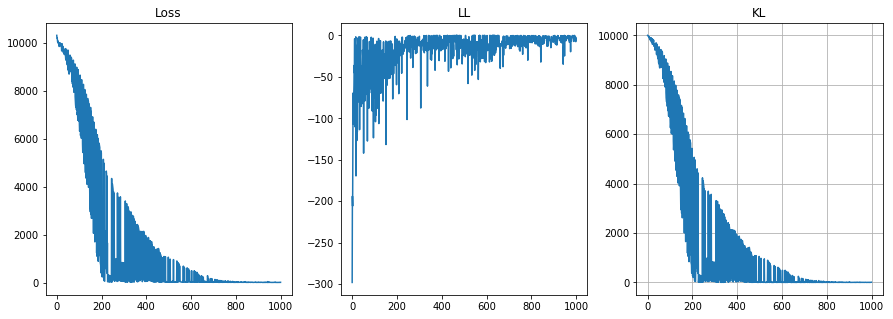

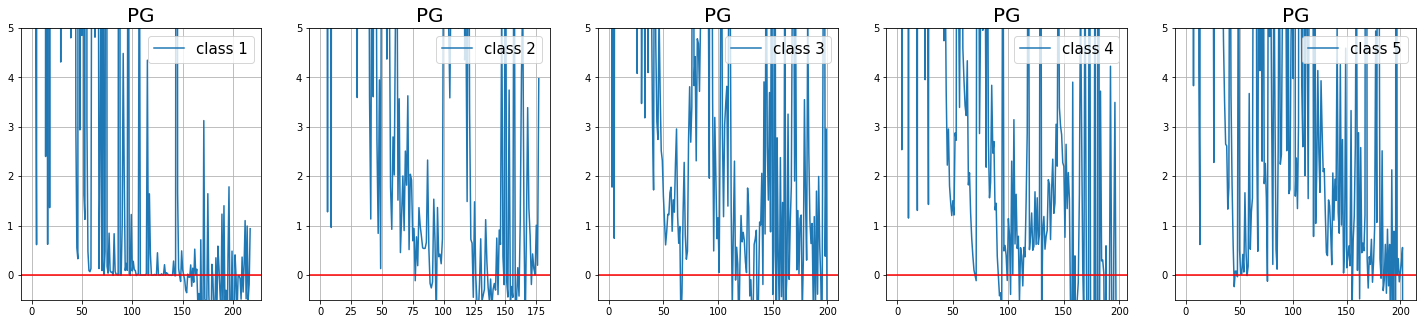

In [41]:
%%time
results = run(fc_size=1024, num_layers=2,
              lr=0.0001, betas=(0.1, 0.9))

In [42]:
steps, chosen_classes, pgs, real_counters, model, train_logs = results

In [43]:
print(model)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=50, out_features=1024)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=512, out_features=2)
  (fc_logvar): Linear(in_features=512, out_features=2)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=512)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=100)
  )
)


In [44]:
int((np.array(pgs)<0).mean()*100)

17

In [45]:
train_logs[1][-10:]

[-4.075565,
 -5.0041456,
 -0.022384552,
 -6.447577,
 -6.4584813,
 -5.8951445,
 -1.1172922,
 -2.7657332,
 -7.636908,
 -3.1948621]

In [46]:
model.eval()
recon_batch, log_probs, mu, logvar = model(convert_to_var(X_test))
recon_batch = recon_batch.data.numpy()
log_probs = log_probs.data.numpy()
mu = mu.data.numpy()
logvar = logvar.data.numpy()
std = np.exp(0.5*logvar)

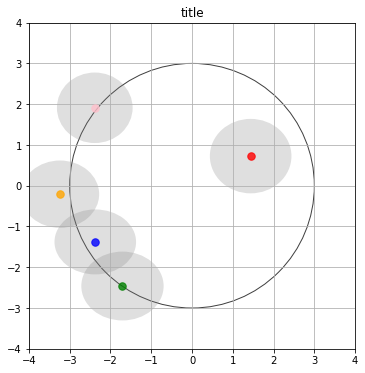

In [47]:
plot_point_with_std(mu, std)

In [48]:
recon_batch.sum(axis=1)

array([12.516272, 26.158188, 33.55051 , 39.99716 , 47.25543 ],
      dtype=float32)

##### Rmsprop

CPU times: user 52.6 s, sys: 596 ms, total: 53.2 s
Wall time: 18.6 s


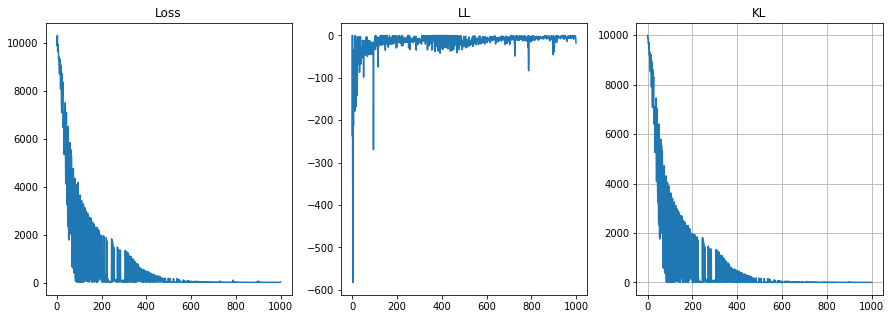

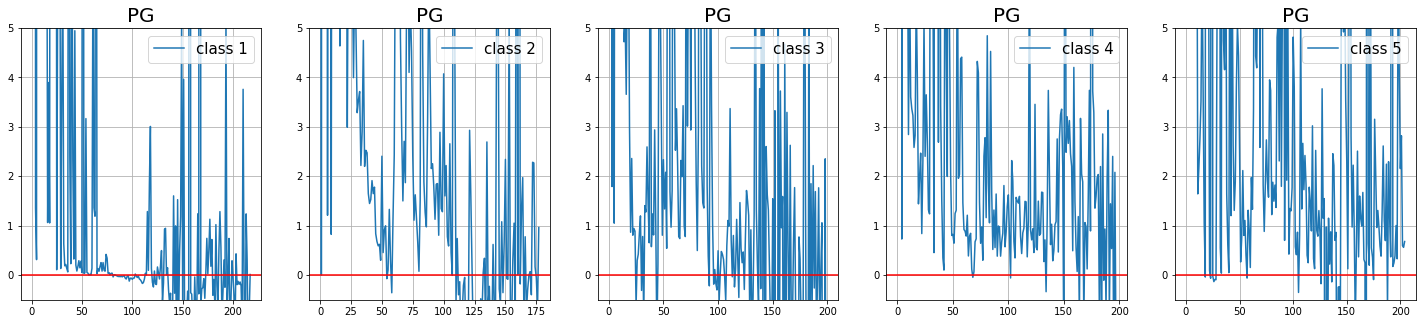

In [49]:
%%time
results = run(fc_size=1024, num_layers=2,
              use_adam=False, lr=0.0001, momentum=0)

In [50]:
steps, chosen_classes, pgs, real_counters, model, train_logs = results

In [51]:
train_logs[1][-10:]

[-6.323571,
 -2.5605745,
 -0.5286494,
 -4.8602295,
 -4.1842966,
 -4.362208,
 -1.3891984,
 -3.4316056,
 -4.134874,
 -17.773724]

In [52]:
int((np.array(pgs)<0).mean()*100)

21

In [53]:
model.eval()
recon_batch, log_probs, mu, logvar = model(convert_to_var(X_test))
recon_batch = recon_batch.data.numpy()
log_probs = log_probs.data.numpy()
mu = mu.data.numpy()
logvar = logvar.data.numpy()
std = np.exp(0.5*logvar)

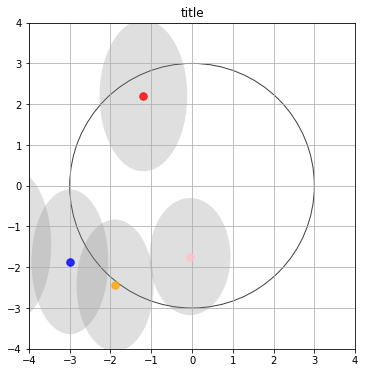

In [54]:
plot_point_with_std(mu, std)

In [55]:
model = VAE()
for param in model.parameters():
    p = param.data.numpy()
    if len(p.shape) == 2:
        print('W', p.min())
    else:
        print('b', p.min())
        print('\n')

W -0.31608945
W -0.031249955
W -0.044145778
W -0.044117317
b -0.02144598


W -0.70686054
b -0.70588905


W -0.044194147
b -0.043876696


W -0.031248257
b -0.021115884




## Пример 2
4 слоя

##### Adam

CPU times: user 1min 7s, sys: 564 ms, total: 1min 8s
Wall time: 24.3 s


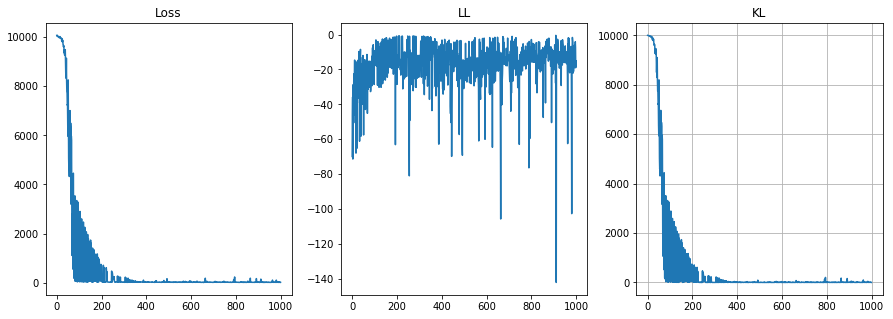

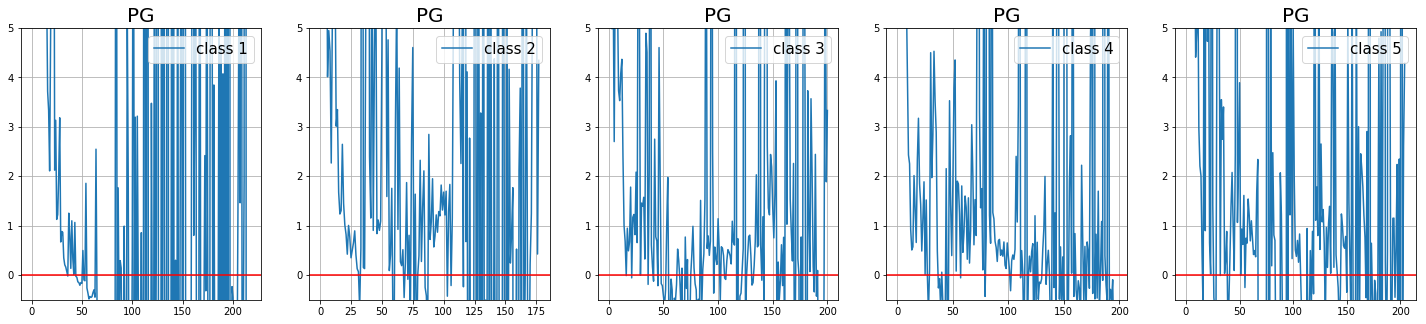

In [56]:
%%time
results = run(fc_size=1024, num_layers=4,
             lr=0.0001, betas=(0.01, 0.99))

In [57]:
steps, chosen_classes, pgs, real_counters, model, train_logs = results

In [58]:
(np.array(pgs)<0).mean()*100

34.699999999999996

In [59]:
train_logs[1][-10:]

[-9.549205,
 -13.440989,
 -6.053587,
 -6.7341785,
 -19.02606,
 -7.998311,
 -4.1314564,
 -7.320943,
 -18.959631,
 -15.077827]

In [60]:
model.eval()
recon_batch, log_probs, mu, logvar = model(convert_to_var(X_test))
recon_batch = recon_batch.data.numpy()
log_probs = log_probs.data.numpy()
mu = mu.data.numpy()
logvar = logvar.data.numpy()
std = np.exp(0.5*logvar)

In [61]:
mu

array([[ 3.817566  ,  3.7946014 ],
       [ 2.7983246 ,  2.75029   ],
       [ 0.8026581 ,  0.71987915],
       [-0.46338654, -0.55892944],
       [-0.5910568 , -0.7033081 ]], dtype=float32)

In [62]:
std

array([[0.85676134, 0.71715814],
       [0.8517925 , 0.72384024],
       [0.8454272 , 0.72876185],
       [0.84368324, 0.7247546 ],
       [0.8406401 , 0.7247995 ]], dtype=float32)

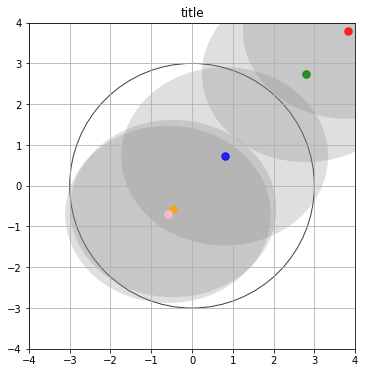

In [63]:
plot_point_with_std(mu, std)

In [64]:
for param in model.parameters():
    p = param.data.numpy()
    if len(p.shape) == 2:
        print('W', p.min())
    else:
        print('b', p.min())
        print('\n')

W -0.14952075
W -0.04438681
W -0.055651482
W -0.0675622
W -0.10446362
W -0.0872696
b -0.0381813


W -0.7006893
b -0.69360137


W -0.10218846
b -0.09373562


W -0.07692418
b -0.06837581


W -0.061516326
b -0.0470418


W -0.06918308
b -0.047563437




In [ ]:
probs, log_probs, mu, logvar = model(convert_to_var(X_test))

In [ ]:
probs = probs.data.numpy().mean(axis=1)
log_probs = log_probs.data.numpy().mean(axis=1)
mu = mu.data.numpy()
logvar = logvar.data.numpy()
std = np.exp(0.5*logvar)

In [ ]:
plot_point_with_std(mu, std)

In [ ]:
pseudo_counts = [[] for _ in range(num_classes)]
damped_pgs_by_classes = [[] for _ in range(num_classes)]

for i in range(len(steps)):
    cl = chosen_classes[i]
    pg = pgs[i]
    t = steps[i]
    
    damp_coef=1/t
    pseudo_count = get_pseudo_count_from_pg(pg, damp_coef=damp_coef)
    
    for j in range(num_classes):
        if j == cl:
            pseudo_counts[j].append(pseudo_count)
            damped_pgs_by_classes[j].append(damp_coef*pg)


In [ ]:
for i in range(len(pseudo_counts[0])):
    print(pseudo_counts[0][i], damped_pgs_by_classes[0][i])

In [ ]:
plt.plot(pseudo_counts[0])

In [ ]:
plt.plot([t for t in pseudo_counts[0] if t < 9000])

In [ ]:
def plot_counters(real_counters, pseudo_counters):
    plt.figure(figsize=(10,10))
    
    n = len(real_counters[0])

    plt.subplot(211)
    plt.plot(np.arange(n), real_counters[0], label='Frequent event (class: 0)')
    plt.plot(np.arange(n), real_counters[3], label='Rare event (class: 3)')
    plt.legend(loc='upper left', fontsize=12)
    plt.title('Real counters', fontsize=20)
    
    plt.subplot(212)
    plt.plot(np.arange(n), pseudo_counters[0], label='Frequent event (class: 0)')
    plt.plot(np.arange(n), pseudo_counters[3], label='Rare event (class: 3)')
    plt.legend(loc='upper left', fontsize=12)
    plt.title('Pseudo counters', fontsize=20)

In [ ]:
plot_counters(real_counters, pseudo_counters)